In [1]:
import pandas as pd
from DataGen import DataGen

D = DataGen()

/opt/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1: Training Loss: 2.6750 Validation Loss: 2.2065
Epoch 2: Training Loss: 2.6048 Validation Loss: 2.2259
Epoch 3: Training Loss: 2.5964 Validation Loss: 2.1432
Epoch 4: Training Loss: 2.5862 Validation Loss: 2.1585
Epoch 5: Training Loss: 2.5823 Validation Loss: 2.1227
Epoch 6: Training Loss: 2.5863 Validation Loss: 2.1459
Epoch 7: Training Loss: 2.5833 Validation Loss: 2.1375
Epoch 8: Training Loss: 2.5836 Validation Loss: 2.1226
Epoch 9: Training Loss: 2.5799 Validation Loss: 2.1348
Epoch 10: Training Loss: 2.5802 Validation Loss: 2.1759
Epoch 11: Training Loss: 2.5809 Validation Loss: 2.1235
Epoch 12: Training Loss: 2.5787 Validation Loss: 2.1719
Epoch 13: Training Loss: 2.5816 Validation Loss: 2.1232
Epoch 14: Training Loss: 2.5806 Validation Loss: 2.1264
Epoch 15: Training Loss: 2.5808 Validation Loss: 2.1435


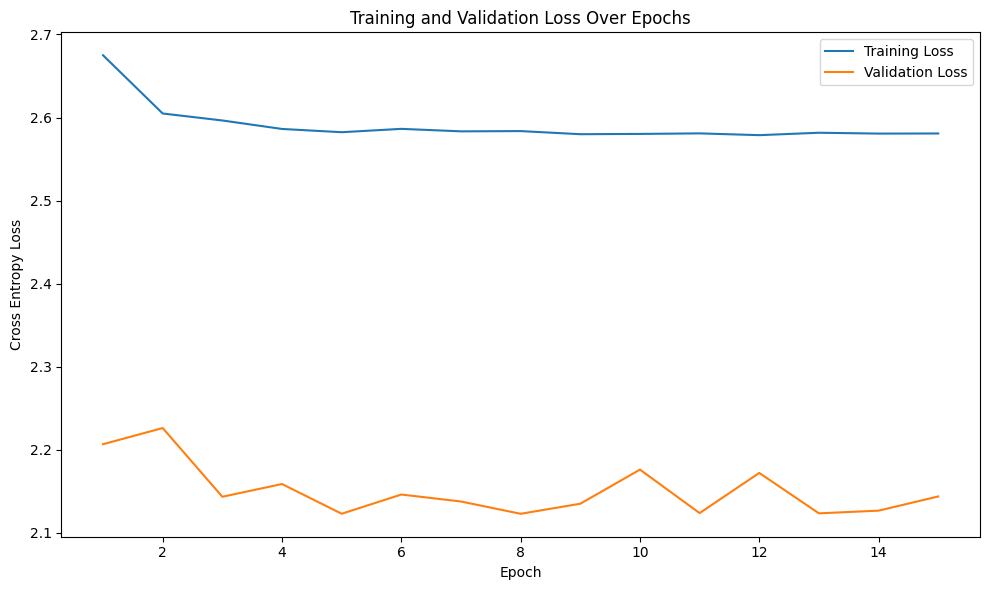

/opt/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1: Training Loss: 3.0504 Validation Loss: 2.9735
Epoch 2: Training Loss: 3.1075 Validation Loss: 2.9654
Epoch 3: Training Loss: 3.1083 Validation Loss: 3.0170
Epoch 4: Training Loss: 3.1073 Validation Loss: 3.0375
Epoch 5: Training Loss: 3.1079 Validation Loss: 2.9085


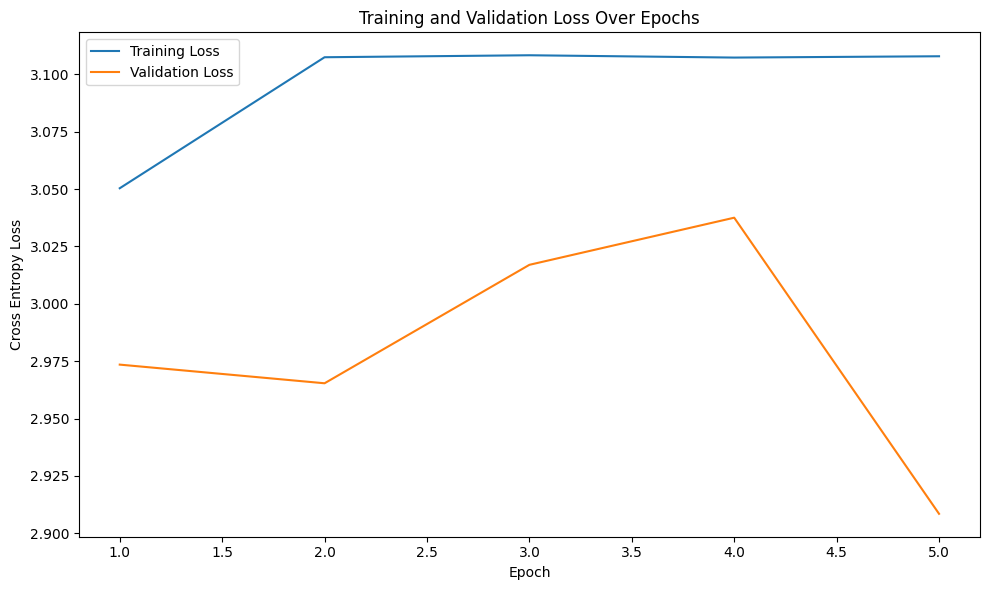

Epoch 1: Training Loss: 2.8929 Validation Loss: 2.8517
Epoch 2: Training Loss: 2.8896 Validation Loss: 2.8409
Epoch 3: Training Loss: 2.8888 Validation Loss: 2.8058
Epoch 4: Training Loss: 2.8888 Validation Loss: 2.8640
Epoch 5: Training Loss: 2.8892 Validation Loss: 2.8266
Epoch 6: Training Loss: 2.8893 Validation Loss: 2.8667
Epoch 7: Training Loss: 2.8893 Validation Loss: 2.8362
Epoch 8: Training Loss: 2.8886 Validation Loss: 2.8287
Epoch 9: Training Loss: 2.8881 Validation Loss: 2.8359
Epoch 10: Training Loss: 2.8885 Validation Loss: 2.8128
Epoch 11: Training Loss: 2.8895 Validation Loss: 2.8770
Epoch 12: Training Loss: 2.8886 Validation Loss: 2.8760
Epoch 13: Training Loss: 2.8895 Validation Loss: 2.7970
Epoch 14: Training Loss: 2.8891 Validation Loss: 2.8373
Epoch 15: Training Loss: 2.8888 Validation Loss: 2.8209


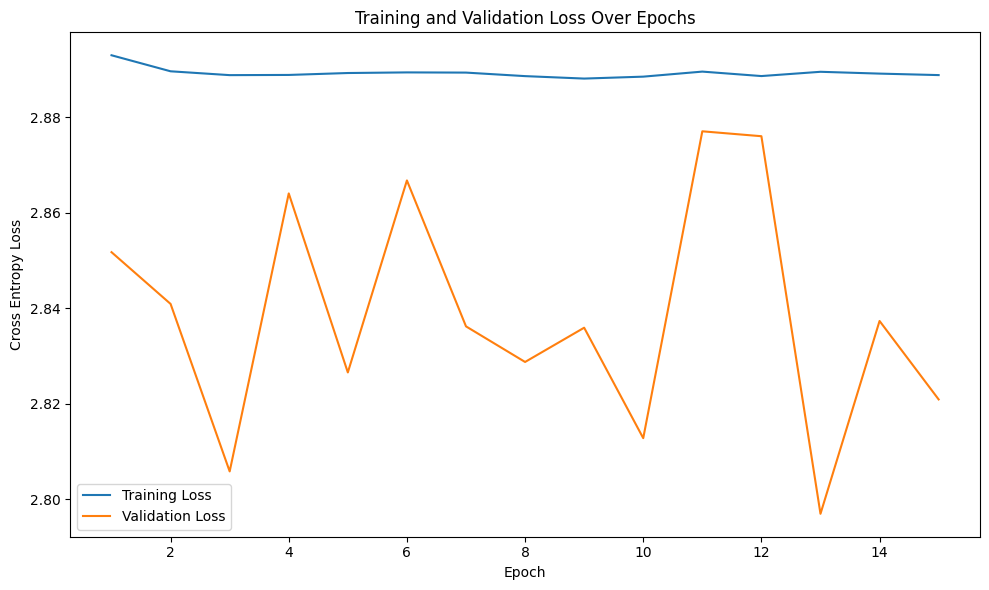

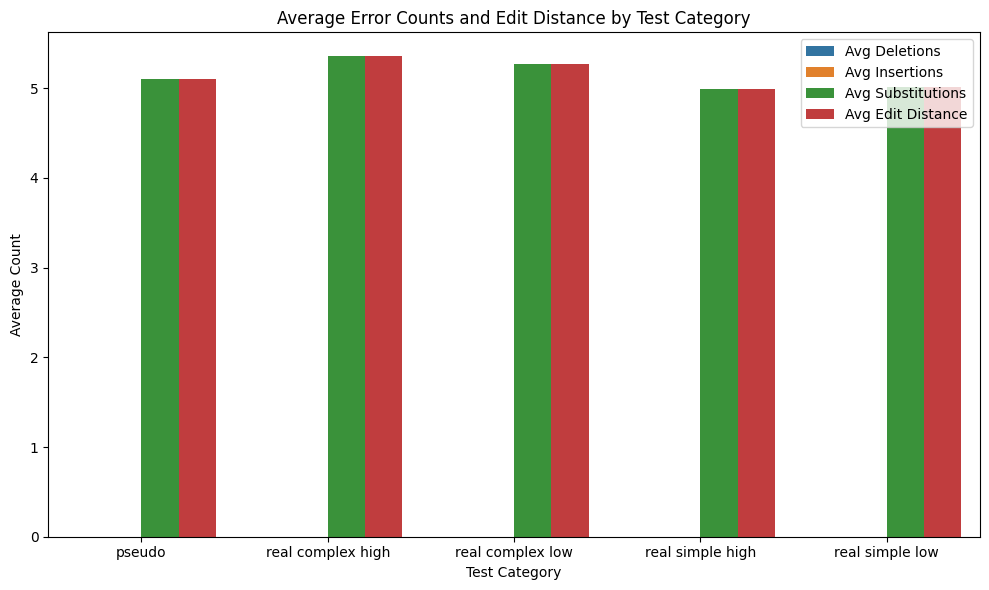

In [5]:
from train_repetition import train_repetition

eval_data = train_repetition(D, grid_search=3)

In [3]:
pd.set_option('display.max_rows', 2000)
eval_data

,Word,Length,Frequency,Zipf Frequency,Morph Complexity,Lexicality,Part of Speech,Phonemes,Prediction,Deletions,Insertions,Substitutions,Edit Distance,Category
0,bathmat,7,low,1.55,complex,real,NOUN,"[B, AE1, TH, M, AH0, T]","[B, AE1, IY0, M, AH0, T]",0,0,1,1,real complex low
1,decoder,7,low,2.84,complex,real,NOUN,"[D, IH0, K, OW1, D, ER0]","[D, IH0, K, OW1, D, D]",0,0,1,1,real complex low
2,defiant,7,low,3.21,complex,real,ADJ,"[D, IH0, F, AY1, AH0, N, T]","[D, IH0, F, B, AH0, N, T]",0,0,1,1,real complex low
3,padlock,7,low,2.68,complex,real,NOUN,"[P, AE1, D, L, AA2, K]","[P, AE1, D, L, AH1, K]",0,0,1,1,real complex low
4,immoral,7,low,3.46,complex,real,ADJ,"[IH0, M, AO1, R, AH0, L]","[IH0, M, V, R, AH0, L]",0,0,1,1,real complex low
5,nonstop,7,low,3.37,complex,real,ADJ,"[N, AA2, N, S, T, AA1, P]","[N, AH1, N, S, T, AA1, P]",0,0,1,1,real complex low
6,parasol,7,low,2.63,complex,real,PROPN,"[P, EH1, R, AH0, S, AO2, L]","[P, EH1, R, AH0, S, AA1, L]",0,0,1,1,real complex low
7,reactor,7,low,3.83,complex,real,NOUN,"[R, IY0, AE1, K, T, ER0]","[R, IY0, AE1, K, T, D]",0,0,1,1,real complex low
8,recycle,7,low,3.35,complex,real,NOUN,"[R, IY0, S, AY1, K, AH0, L]","[R, IY0, S, B, K, AH0, L]",0,0,1,1,real complex low
9,reenact,7,low,2.42,complex,real,VERB,"[R, IY0, IH0, N, AE1, K, T]","[R, IY0, IH0, N, AE1, K, T]",0,0,0,0,real complex low
